# Part III: Generate KDEs and obtain persistence diagrams

- Compute the four cardinal directional distance transforms (distance to the closest cell wall along a given cardinal direction) for the cross section.
- Compute a KDE with a grid of stepsize `stepsize`
- Correct KDE boundaries: treat cell walls and nuclei as steep walls.
- Compute sub or superlevel persistence

Notice that the KDE itself is not saved, as it can easily computed again if necessary.
- Saving it would be quite expensive in the long run

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from glob import glob
import os
from scipy import ndimage, interpolate, spatial, stats

from KDEpy import FFTKDE
import gudhi as gd
import json
import persim

import utils
from importlib import reload

# Load all general data

- Same setup as in the previous notebooks

In [40]:
levels = ['sub', 'sup']
pows2 = 2**np.arange(20) + 1
fs = 15
bw = 20
PP = 6
stepsize = 3
pp = 0
nuclei_mask_cutoff = 1

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
sample = 'D2'

ksrc += sample + os.sep
dst = '../animation/' + sample + '/'

#wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(tf.imread(wsrc + sample + '_dams.tif').astype(bool), ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col = 0)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv', index_col=-1)
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')

tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

transcriptomes = np.asarray(metatrans['gene'])
translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
zmax = tlocs['Z'].max()
zmin = tlocs['Z'].min()

Detected 2937 cells
Detected 1365 nuclei


# Compute transcript weights for KDE

- If transcript is close to a border (cell wall or nucleus), it becomes heavier to then reflect the Gaussian "weight"
- Inspired from this thread in [crossvalidated](https://stats.stackexchange.com/questions/65866/good-methods-for-density-plots-of-non-negative-variables-in-r/).
- In this case, the weight variability is restrained: it will be at most `2`
- An unaffected transcript will have weight `1` instead.

![](https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/main/mcarto/figs/D2_GLYMA_05G092200_1749_1748_distance_transform.jpg)

# Select a cell and then a gene

- Get a nice bounding box to just focus on a given cell `cidx`
- A tri-color image `cell` is produced, where
    - `0` is for nuclei and walls
    - `1` for other cytoplasm
    - `2` for the cytosol of the specified cell 
- Produce a regular grid for that box of stepsize `stepsize`
- The grid extends beyond the box by a factor `pad` to account for numerical overflows when the computing KDE
- Get the transcripts of the gene inside that cell

In [53]:
foo = metacell.loc[(metacell['number_nuclei'] == 0).values & (transcell.loc[transcriptomes[tidx]] > 1000).values].copy()
foo['xratio'] = np.minimum( (foo['length']/foo['height']).values, (foo['height']/foo['length']).values )
foo.sort_values(by=['xratio', 'total_area'], ascending=[False, True])

,x0,x1,y0,y1,length,height,total_area,nuclei_area,cyto_area,c2t_area_ratio,number_nuclei,orig_comX,orig_comY,ndimage_comX,ndimage_comY,orig_cellID,xratio
ndimage_cellID,,,,,,,,,,,,,,,,,
1,0,17152,0,17152,17152,17152,114911591,36950,114874641,0.999678,0,7865.12,8160.49,7865.56,8160.76,1,1.000000
282,7271,7746,3371,3880,475,509,134144,0,134144,1.000000,0,7470.90,3623.71,7470.75,3623.55,283,0.933202
1606,6942,7532,9243,9909,590,666,203107,0,203107,1.000000,0,7250.34,9564.09,7249.61,9563.84,1607,0.885886
642,5734,6239,5162,5604,505,442,133571,0,133571,1.000000,0,6000.24,5372.67,5999.76,5372.16,643,0.875248
188,7823,8444,2945,3685,621,740,236885,0,236885,1.000000,0,8140.63,3270.25,8140.11,3270.17,188,0.839189
2298,8368,8973,12204,12694,605,490,141332,0,141332,1.000000,0,8693.27,12465.43,8692.54,12465.14,2299,0.809917
2227,13375,13972,11851,12613,597,762,200958,0,200958,1.000000,0,13676.01,12211.17,13675.58,12210.85,2228,0.783465
385,9083,9490,3895,4490,407,595,127261,0,127261,1.000000,0,9302.02,4204.28,9301.48,4203.65,388,0.684034
2364,10484,10935,12481,13150,451,669,189302,251,189051,0.998674,0,10696.95,12809.50,10696.50,12808.96,2364,0.674141


In [54]:
level = 'sub'
cidx = 282

s_ = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([label.shape[0], metacell.loc[cidx, 'y1'] + PP])],
      np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([label.shape[1], metacell.loc[cidx, 'x1'] + PP])])
extent = (s_[1].start, s_[1].stop, s_[0].start, s_[0].stop)


cell = label[s_].copy()
cell[ label[s_] == 0 ] = -1
cell[ label[s_] > 0 ] = 0
cell[ label[s_] == cidx ] = nnuc + 1
cell[ lnuc[s_] > 0 ] = lnuc[s_][lnuc[s_] > 0]

maxdims = ( cell.shape[1], cell.shape[0]) 
print('Maxdims:\t',maxdims)
axes, grid, gmask = utils.kde_grid_generator(stepsize=stepsize, maxdims=maxdims, pows2 = pows2, pad=1.5)
grid[:, :2] = grid[:, :2] + np.array([s_[1].start, s_[0].start])
cgrid = grid[gmask].copy()
cgrid[:,:2] = grid[gmask][:,:2] - np.array([s_[1].start, s_[0].start])

nuc_lims = cell_nuc.loc[ (cell_nuc['ndimage_ID'] == cidx), ['ndimage_ID','nuc_ID','N_inside','n_bot','n_top']]
outside_walls = cell[cgrid[:,1],cgrid[:,0]] < 1

tidx = 26

tdst = dst + transcriptomes[tidx] + os.sep
coords = translocs[tidx].loc[:, ['X','Y']].values.T
kdst = dst + transcriptomes[tidx] + os.sep
print(transcriptomes[tidx], metatrans.iloc[tidx]['cyto_number'], kdst, sep='\t')

cmask = label[ coords[1], coords[0] ] == cidx
ccoords = coords[:, cmask ].copy()
print(cidx, ccoords.shape, np.unique(cell), sep='\t')

figdst = dst + transcriptomes[tidx] + '_' + level + 'level_c{}'.format(cidx) + '/'
if not os.path.isdir(figdst):
    os.mkdir(figdst)
    print(figdst)

Maxdims:	 (487, 521)
GLYMA_05G092200	767090	../animation/D2/GLYMA_05G092200/
282	(2, 1327)	[  -1    0  126  140 1366]
../animation/D2/GLYMA_05G092200_sublevel_c282/


# Compute, crop, and correct the KDE

- KDE is mainly sensitive to bandwidth value, and to kernel type to a lesser extent.
- Things are mathematically trickier whenever dealing with more than 1D (we're dealing with 3D in this case)
- There are several well-studied heuristics on how to choose the "best" bandwidth from the data alone.
    - An immediate problem is that most of the advanced heuristics are limited to 1D, but some tinkering can be done for [higher dimensions](https://github.com/tommyod/KDEpy/issues/81).
- In the end, we simply chose `bw = 10` since this is a small value relative to cell size (average side length of a cell is about 175px)
- We want a small bandwidth to highlight density changes across the cytosol within the same cell

### Actual computations

- KDE computed with `KDEpy`, which is surprisingly quick, [just like advertised](https://kdepy.readthedocs.io/en/latest/).
- For comparison we compute an unweighted KDE `uwkde`
- This KDE is then cropped and reweighted to remove the grid padding
- In reality, we want a weighted KDE `kde`, with weights as mentioned above
- It is also cropped and reweighted to remove grid padding
- But then we also remove anything outside the specified cytosol and reweigh again

![](https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/main/mcarto/figs/D2_GLYMA_05G092200_1749_1748_3D_kde_correction.gif)

In [55]:
kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(ccoords.T).evaluate(grid)
kde = kde[gmask]/(np.sum(kde[gmask])*(stepsize**len(coords)))
kde[outside_walls] = 0

kde = kde/(np.sum(kde)*(stepsize**len(coords)))
kde = kde.reshape( list(map(len, axes))[::-1], order='F')
print(np.sum(kde)*(stepsize**len(coords)))
maxkde = np.max(kde)

1.0


In [68]:
cc = gd.CubicalComplex(top_dimensional_cells = utils.get_level_filtration(kde, level) )
pers = cc.persistence(homology_coeff_field=2, min_persistence=1e-15)
bd = np.zeros((len(pers), 3), dtype=float)
for i in range(len(bd)):
    bd[i, 0] = pers[i][0]
    bd[i, 1:] = pers[i][1]

In [150]:
SCALE = 16

cc = gd.CubicalComplex(top_dimensional_cells = utils.get_level_filtration(kde, level) )
pers = cc.persistence(homology_coeff_field=2, min_persistence=1e-15)
bd = np.zeros((len(pers), 3), dtype=float)
for i in range(len(bd)):
    bd[i, 0] = pers[i][0]
    bd[i, 1:] = pers[i][1]
#bd[ bd == np.inf] = kde.max()
bd = bd[ np.all(bd < np.inf, axis=1), :]
bd = pd.DataFrame(bd, columns=['H','birth','death']).astype({'H':int})

ld = [ None for _ in range(2) ]
for k in range(len(ld)):
    
    ld[k] = np.zeros((len(bd[bd['H'] == k]), 2))
    ld[k][:,0] = bd.loc[bd['H'] == k, 'birth']
    ld[k][:,1] = bd.loc[bd['H'] == k, 'death'] - bd.loc[bd['H'] == k, 'birth']
lt_max = max(list(map(np.max, ld)))
for k in range(len(ld)):
    ld[k] = ld[k]/lt_max * (SCALE-1)    

In [163]:
sigma = 1
persw = 1
pixsz = 1
iqr_factor = 1.5

pi_params = {'birth_range':(0, SCALE),
             'pers_range':(0, SCALE),
             'pixel_size': pixsz,
             'weight': 'persistence',
             'weight_params': {'n': persw},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }
                           
pimgr = persim.PersistenceImager(**pi_params)
pimg = np.asarray(pimgr.transform(ld, skew=False))
pimg_max = np.quantile(pimg[pimg > 0], 0.975)

In [100]:
print(kde.shape, grid.shape, grid[gmask].shape, kde.size)

zthr = np.linspace(kde.min(), kde.max()+1e-7, 40)
azim = np.linspace(0, 360, len(zthr), endpoint=False)
X, Y = np.meshgrid(range(kde.shape[1]), range(kde.shape[0]))

(174, 163) (131841, 2) (28362, 2) 28362


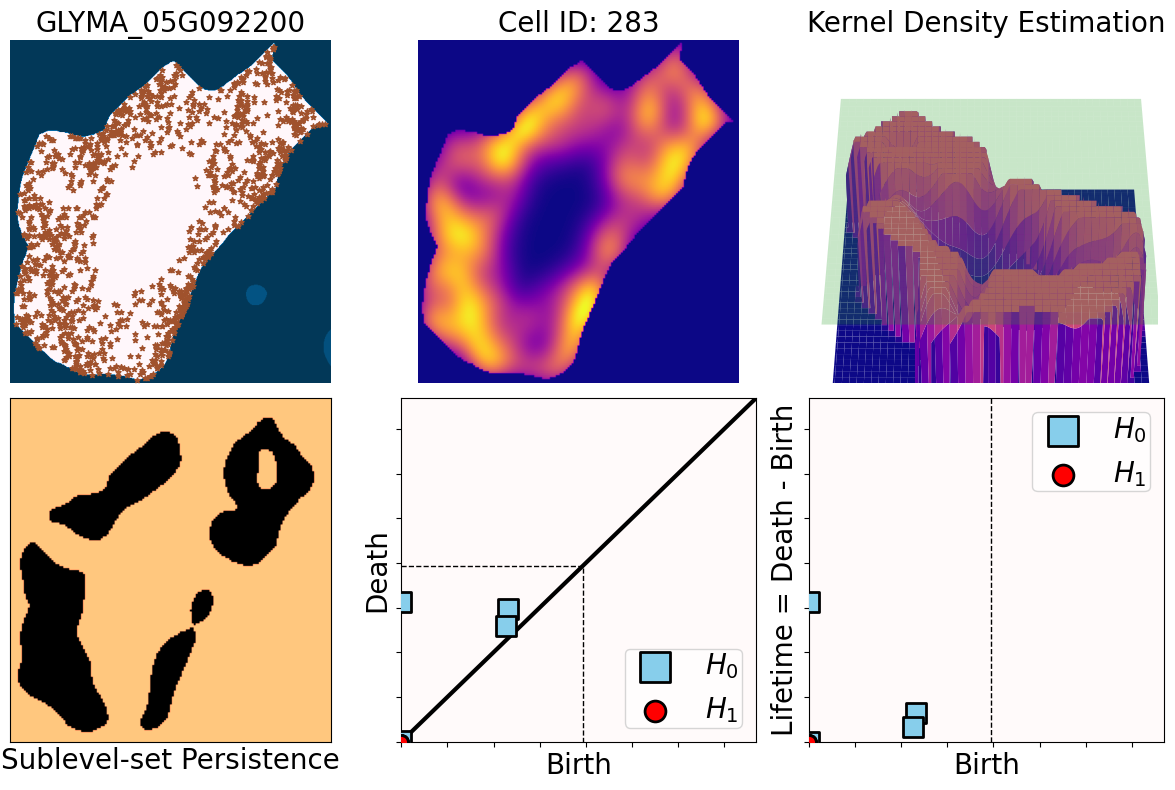

In [101]:
fs = 20
s,S = 15, 100
i = 20

ii = min(i, len(zthr) - 1)
pirange = int(np.round(i * len(pimg)/len(zthr)))
ppimg = np.zeros_like(pimg)
plane = np.zeros_like(kde) + zthr[ii]
heat = kde.copy()
heat[kde > zthr[ii]] = zthr[ii]

fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(2, 3, 1)
ax.imshow(cell, cmap='PuBu_r', origin='lower', extent=extent)
ax.scatter(*ccoords, c='sienna', marker='*', s=s, zorder=3)
ax.set_title(transcriptomes[tidx], fontsize=fs);

ax = fig.add_subplot(2, 3, 2)
ax.imshow(kde, cmap='plasma', origin='lower', extent=extent)
ax.set_title('Cell ID: {}'.format(metacell.loc[cidx, 'orig_cellID']), fontsize=fs)

ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.plot_surface(X, Y, heat, cmap='plasma', zorder=2, vmax=kde.max())
if i < len(zthr):
    ax.plot_surface(X, Y, plane, color='limegreen', alpha=0.25, zorder=3)
ax.set_zlim(zthr[0], zthr[-1])
ax.view_init(elev=45, azim=azim[i%len(azim)], roll=0)
ax.set_box_aspect(aspect=(4,4,3), zoom=1.65)
ax.set_title('Kernel Density Estimation', fontsize=fs);

ax = fig.add_subplot(2, 3, 4)
ax.imshow( kde <= zthr[ii], cmap='copper', origin='lower', vmin=0, vmax=1, zorder=1)
ax.set_xlabel('Sublevel-set Persistence', fontsize=fs);
ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)

ax = fig.add_subplot(2,3,5)
ax.axline((0,0), slope=1, c='k', lw=3, zorder=1)
if i < len(zthr):
    ax.plot([0, zthr[ii], zthr[ii]],[zthr[ii], zthr[ii], 0], lw=1, c='k', ls='--', zorder=2)
ax.set_xlim(0, zthr[-1]); ax.set_ylim(0, zthr[-1])

h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h0 = ax.scatter(*h, marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h1 = ax.scatter(*h, marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')

ax.set_xlabel('Birth', fontsize=fs)
ax.set_ylabel('Death', fontsize=fs)
ax.set_facecolor('snow')
ax.legend([h0,h1],['$H_0$', '$H_1$'], loc='lower right', fontsize=fs, borderpad=0.1, markerscale=1.5)
ax.tick_params(labelbottom=False, labelleft=False)

ax = fig.add_subplot(2,3,6)

ax.axvline(zthr[ii], c='k', lw=1, zorder=2, ls='--')
h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
ax.scatter(h[0], h[1]-h[0], marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
ax.scatter(h[0], h[1]-h[0], marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')

ax.set_xlabel('Birth', fontsize=fs)
ax.set_ylabel('Lifetime = Death - Birth', fontsize=fs)
ax.set_facecolor('snow')
ax.legend([h0,h1],['$H_0$', '$H_1$'], loc='upper right', fontsize=fs, borderpad=0.1, markerscale=1.5)
ax.tick_params(labelbottom=False, labelleft=False)
ax.set_xlim(0, zthr[-1]); ax.set_ylim(0, zthr[-1])

if False:
    for j in range(pirange):
        for k in range(pirange-j):
            jj = min(j, ppimg.shape[0]-1)
            kk = min(k, ppimg.shape[1]-1)
            ppimg[jj, kk] = pimg[jj, kk]        
    ax.imshow(ppimg, origin='lower', cmap='Blues', vmax=pimg.max(), vmin=0, extent=(0,len(pimg),0,len(pimg)))
    ax.axline( ((i+1.75) * len(pimg)/len(zthr),0), slope=-1, c='gray', ls='--');
    ax.set_xlim(0, len(pimg));ax.set_ylim(0, len(pimg));
    ax.set_xlabel('Persistence Images', fontsize=fs);
    ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    for j in range(pirange):
        for k in range(pirange-j):
            if (j < ppimg.shape[0]) & (k < ppimg.shape[1]):
                if pimg[k,j] <= 1:
                    ax.text(j+.5, k+.5, '{}'.format(int(50*pimg[k,j])), color='k', ha='center', va='center_baseline', weight='bold', size=10.5)
                else:
                    ax.text(j+.5, k+.5, '{}'.format(int(50*pimg[k,j])), color='yellow', ha='center', va='center_baseline', weight='bold', size=10.5)

for a in fig.get_axes()[:3]:
    a.axis('off')
    
fig.tight_layout()

In [85]:
fs = 20
s,S = 15, 100
i = 16

for i in range(len(zthr)+1):
    
    ii = min(i, len(zthr) - 1)
    pirange = int(np.round(i * len(pimg)/len(zthr)))
    ppimg = np.zeros_like(pimg)
    plane = np.zeros_like(kde) + zthr[ii]
    heat = kde.copy()
    heat[kde > zthr[ii]] = zthr[ii]
    
    fig = plt.figure(figsize=(12,8))
    
    ax = fig.add_subplot(2, 3, 1)
    ax.imshow(cell, cmap='PuBu_r', origin='lower', extent=extent)
    ax.scatter(*ccoords, c='sienna', marker='*', s=s, zorder=3)
    ax.set_title(transcriptomes[tidx], fontsize=fs);
    
    ax = fig.add_subplot(2, 3, 2)
    ax.imshow(kde, cmap='plasma', origin='lower', extent=extent)
    ax.set_title('Cell ID: {}'.format(metacell.loc[cidx, 'orig_cellID']), fontsize=fs)
    
    ax = fig.add_subplot(2, 3, 3, projection='3d')
    ax.plot_surface(X, Y, heat, cmap='plasma', zorder=2, vmax=kde.max())
    if i < len(zthr):
        ax.plot_surface(X, Y, plane, color='limegreen', alpha=0.25, zorder=3)
    ax.set_zlim(zthr[0], zthr[-1])
    ax.view_init(elev=45, azim=azim[i%len(azim)], roll=0)
    ax.set_box_aspect(aspect=(4,4,3), zoom=1.65)
    ax.set_title('Kernel Density Estimation', fontsize=fs);
    
    ax = fig.add_subplot(2, 3, 4)
    ax.imshow( kde <= zthr[ii], cmap='copper', origin='lower', vmin=0, vmax=1, zorder=1)
    ax.set_xlabel('Sublevel-set Persistence', fontsize=fs);
    ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    
    ax = fig.add_subplot(2,3,5)
    ax.axline((0,0), slope=1, c='k', lw=3, zorder=1)
    if i < len(zthr):
        ax.plot([0, zthr[ii], zthr[ii]],[zthr[ii], zthr[ii], 0], lw=1, c='k', ls='--', zorder=2)
    ax.set_xlim(0, zthr[-1]); ax.set_ylim(0, zthr[-1])
    
    h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
    h0 = ax.scatter(*h, marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
    
    h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
    h1 = ax.scatter(*h, marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')
    
    ax.set_xlabel('Birth', fontsize=fs)
    ax.set_ylabel('Death', fontsize=fs)
    ax.set_facecolor('snow')
    ax.legend([h0,h1],['$H_0$', '$H_1$'], loc='lower right', fontsize=fs, borderpad=0.1, markerscale=1.5)
    ax.tick_params(labelbottom=False, labelleft=False)
    
    ax = fig.add_subplot(2,3,6)
    ax.axvline(zthr[ii], c='k', lw=1, zorder=2, ls='--')

    h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
    ax.scatter(h[0], h[1]-h[0], marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
    h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
    ax.scatter(h[0], h[1]-h[0], marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')
    
    ax.set_xlabel('Birth', fontsize=fs)
    ax.set_ylabel('Lifetime = Death - Birth', fontsize=fs)
    ax.set_facecolor('snow')
    ax.legend([h0,h1],['$H_0$', '$H_1$'], loc='upper right', fontsize=fs, borderpad=0.1, markerscale=1.5)
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.set_xlim(0, zthr[-1]); ax.set_ylim(0, zthr[-1])
    
    if False:
        for j in range(pirange):
            for k in range(pirange-j):
                jj = min(j, ppimg.shape[0]-1)
                kk = min(k, ppimg.shape[1]-1)
                ppimg[jj, kk] = pimg[jj, kk]        
        ax.imshow(ppimg, origin='lower', cmap='Blues', vmax=pimg.max(), vmin=0, extent=(0,len(pimg),0,len(pimg)))
        ax.axline( ((i+1.75) * len(pimg)/len(zthr),0), slope=-1, c='gray', ls='--');
        ax.set_xlim(0, len(pimg));ax.set_ylim(0, len(pimg));
        ax.set_xlabel('Persistence Images', fontsize=fs);
        ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
        for j in range(pirange):
            for k in range(pirange-j):
                if (j < ppimg.shape[0]) & (k < ppimg.shape[1]):
                    if pimg[k,j] <= 1:
                        ax.text(j+.5, k+.5, '{}'.format(int(50*pimg[k,j])), color='k', ha='center', va='center_baseline', weight='bold', size=10.5)
                    else:
                        ax.text(j+.5, k+.5, '{}'.format(int(50*pimg[k,j])), color='yellow', ha='center', va='center_baseline', weight='bold', size=10.5)

    for a in fig.get_axes()[:3]:
        a.axis('off')
        
    fig.tight_layout()
    
    filename = figdst + transcriptomes[tidx] + '_TDA_c{:05d}_{:02d}.png'.format(cidx, i)
    plt.savefig(filename, format='png', dpi=72, bbox_inches='tight')
    plt.close()

In [172]:
pirange

49

../animation/D2/GLYMA_05G092200_sublevel_c282/GLYMA_05G092200_TDA_c00282_122.png


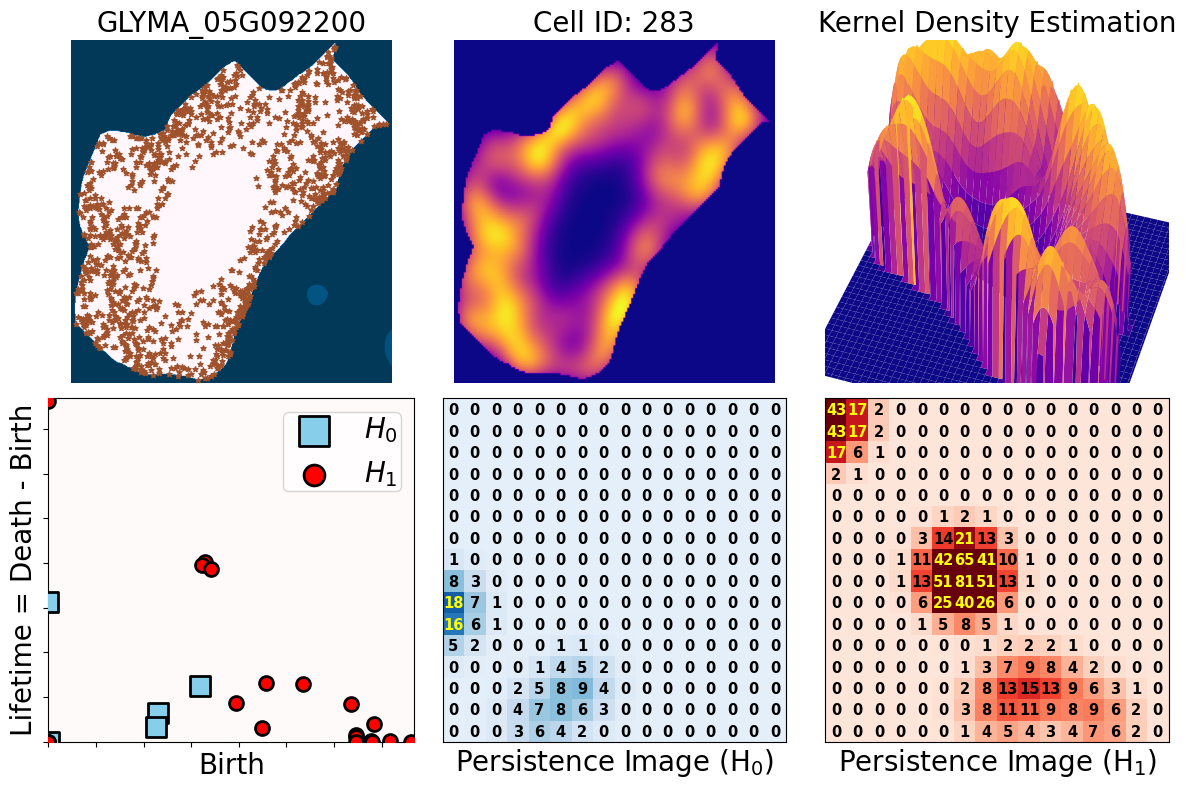

In [188]:
pimg_max = np.quantile(pimg[pimg > 0], 0.975)
i = 3*len(zthr) + 2

ii = min(i, len(zthr) - 1)
pirange = int(np.round(i * len(pimg[0])/len(zthr)))
ppimg = np.zeros_like(pimg)
plane = np.zeros_like(kde) + zthr[ii]
heat = kde.copy()
heat[kde > zthr[ii]] = zthr[ii]

fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(2, 3, 1)
ax.imshow(cell, cmap='PuBu_r', origin='lower', extent=extent)
ax.scatter(*ccoords, c='sienna', marker='*', s=s, zorder=3)
ax.set_title(transcriptomes[tidx], fontsize=fs);

ax = fig.add_subplot(2, 3, 2)
ax.imshow(kde, cmap='plasma', origin='lower', extent=extent)
ax.set_title('Cell ID: {}'.format(metacell.loc[cidx, 'orig_cellID']), fontsize=fs)

ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.plot_surface(X, Y, heat, cmap='plasma', zorder=2, vmax=kde.max())
if i < len(zthr):
    ax.plot_surface(X, Y, plane, color='limegreen', alpha=0.25, zorder=3)
ax.set_zlim(zthr[0], zthr[-1])
ax.view_init(elev=45, azim=azim[i%len(azim)], roll=0)
ax.set_box_aspect(aspect=(4,4,3), zoom=1.65)
ax.set_title('Kernel Density Estimation', fontsize=fs);

ax = fig.add_subplot(2, 3, 4)

h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
ax.scatter(h[0], h[1]-h[0], marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
ax.scatter(h[0], h[1]-h[0], marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')

ax.set_xlabel('Birth', fontsize=fs)
ax.set_ylabel('Lifetime = Death - Birth', fontsize=fs)
ax.set_facecolor('snow')
ax.legend([h0,h1],['$H_0$', '$H_1$'], loc='upper right', fontsize=fs, borderpad=0.1, markerscale=1.5)
ax.tick_params(labelbottom=False, labelleft=False)
ax.set_xlim(0, zthr[-1]); ax.set_ylim(0, zthr[-1])

ax = fig.add_subplot(2,3,5)

ax.imshow(pimg[0].T, origin='lower', cmap='Blues', vmin=-0.1*pimg_max, vmax=pimg_max, extent=(0,len(pimg[0]),0,len(pimg[0])))
ax.set_xlim(0, len(pimg[0]));ax.set_ylim(0, len(pimg[0]));
ax.set_xlabel('Persistence Image (H$_0$)', fontsize=fs);
ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
if i > 3*len(zthr):
    for j in range(pimg[0].shape[0]):
        for k in range(pimg[0].shape[1]):
            if 25*pimg[0,j,k] <= 16:
                ax.text(j+.5, k+.5, '{}'.format(int(25*pimg[0,j,k])), color='k', ha='center', va='center_baseline', weight='bold', size=10.5)
            else:
                ax.text(j+.5, k+.5, '{}'.format(int(25*pimg[0,j,k])), color='yellow', ha='center', va='center_baseline', weight='bold', size=10.5)


ax = fig.add_subplot(2,3,6)
      
ax.imshow(pimg[1].T, origin='lower', cmap='Reds', vmin=-0.1*pimg_max, vmax=pimg_max, extent=(0,len(pimg[1]),0,len(pimg[1])))
ax.set_xlim(0, len(pimg[1]));ax.set_ylim(0, len(pimg[1]));
ax.set_xlabel('Persistence Image (H$_1$)', fontsize=fs);
ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
if i > 3*len(zthr):
    for j in range(pimg[1].shape[0]):
        for k in range(pimg[1].shape[1]):
            if 25*pimg[1,j,k] <= 16:
                ax.text(j+.5, k+.5, '{}'.format(int(25*pimg[1,j,k])), color='k', ha='center', va='center_baseline', weight='bold', size=10.5)
            else:
                ax.text(j+.5, k+.5, '{}'.format(int(25*pimg[1,j,k])), color='yellow', ha='center', va='center_baseline', weight='bold', size=10.5)


for a in fig.get_axes()[:3]:
    a.axis('off')
    
fig.tight_layout()
filename = figdst + transcriptomes[tidx] + '_TDA_c{:05d}_{:03d}.png'.format(cidx, i)
print(filename)
plt.savefig(filename, format='png', dpi=72, bbox_inches='tight')

# Cubical persistence

- Cubical persistence computed with [`gudhi`](https://gudhi.inria.fr/), which does a decent job whenever images are less than 1000 x 1000 px in size.
- Persistence computed directly on 3D images produced by the KDE
- Played with both sublevel and superlevel filtrations
- Probably we'll stick with superlevel later down the line, as it is intuitively easier to explain and visualize.

In [134]:
if i > 3*len(zthr):
    for j in range(pimg[0].shape[0]):
        for k in range(pimg[0].shape[1]):
            if pimg[0,k,j] <= 1:
                ax.text(j+.5, k+.5, '{}'.format(int(25*pimg[0,k,j])), color='k', ha='center', va='center_baseline', weight='bold', size=10.5)
            else:
                ax.text(j+.5, k+.5, '{}'.format(int(25*pimg[0,k,j])), color='yellow', ha='center', va='center_baseline', weight='bold', size=10.5)


,birth,death
20,1.962083e-09,6.264967e-06
21,6.368319e-06,8.856922e-06
22,4.622853e-06,5.924859e-06
23,4.527073e-06,5.179866e-06
24,4.168074e-09,4.227741e-09


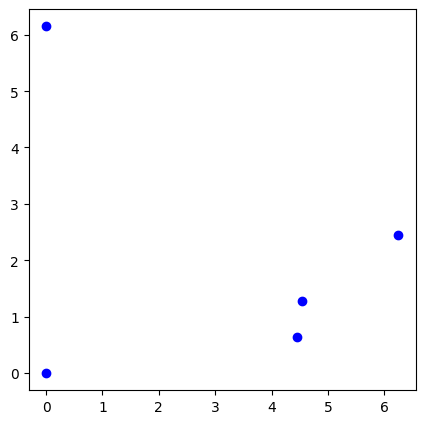

In [145]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

k = 0
ax[j].scatter(*(ld[k].T), marker='o', c='b')
ax[j].set_aspect('equal');

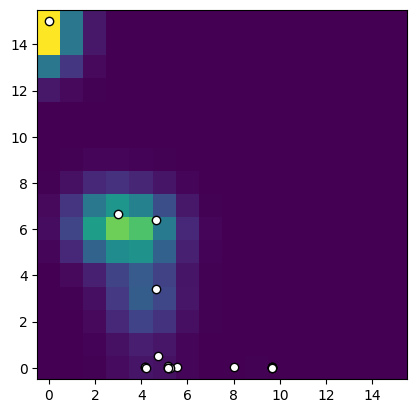

In [205]:
plt.imshow(pimg.T, origin='lower')
plt.scatter(ld[:,0], ld[:,1], marker='o', linewidth=1, edgecolor='k', color='w');

# What if we just want to focus on a subset of cells and genes?

In [25]:
cell_focus = pd.read_csv('../data/D2_data/infected_cells_ids.csv')
gene_focus = pd.read_csv('../data/D2_data/genes_to_focus_infection.csv')

if 'gene_ID' in gene_focus.columns:
    gid = gene_focus['gene_ID'].values
else:
    gid = np.zeros(len(gene_focus), dtype=int)
    for i in range(len(gid)):
        gid[i] = np.nonzero(transcriptomes == gene_focus.iloc[i,0])[0][0]
        
if 'ndimage_ID' in cell_focus.columns:
    cid = cell_focus['ndimage_ID'].values
else:
    cid = np.zeros(len(cell_focus), dtype=int)
    for i in range(len(cid)):
        cid[i] = metacell[metacell['orig_cellID'] == cell_focus.iloc[i,0]].index[0]